In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Banner advertising understanding

<table align="left">

<a href="https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/generative_ai/content_generation/banner_advertising_understanding.ipynb">
<img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
View on GitHub
</a>
</td>
<td>
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/ai-ml-recipes/main/notebooks/generative_ai/content_generation/banner_advertising_understanding.ipynb">
<img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
</a>
</td>
</table>

## Overview

This notebook shows how to process ads banners images and generate enriched information classifications using a taxonomy using Bigframes and Gemini.  
It reads ads banners images from a GCS bucket and process them using Bigframes and Gemini, leveraging BigQuery's distributed processing capabilities.  

### Setup

Make sure the service account running this notebook has the required permissions:

- **Run the notebook**
    - AI Platform Notebooks Service Agent
    - Notebooks Admin
    - Vertex AI Administrator
- **Read files from bucket**
    - Storage Object Viewer
- **Call Google APIs**
    - Service Usage Consumer

### Imports

In [1]:
!pip install google-cloud-bigquery-connection bigframes -q

In [2]:
import json
import io 
import re

from google.cloud import storage
from google.cloud import bigquery
from google.cloud import bigquery_connection_v1 as bq_connection

import bigframes.pandas as bpd
import pandas as pd

import http.client
import typing
import urllib.request
    
from google.cloud import storage
from IPython.display import display
from PIL import Image

import google.auth
import google.auth.transport.requests
import requests

from tabulate import tabulate

In [2]:
%load_ext google.cloud.bigquery

### Parameters

In [ ]:
PROJECT_ID = "<project_id>"
REGION = "<region>" # ex: us-central1

BUCKET_LOC = "gs://dataproc-metastore-public-binaries/ads_banners_images"

CONNECTION_ID = "<bq_connection>"
DATASET_ID = "<dataset_id>"
OBJECT_TABLE_NAME = "<object_table_name>"

### Create BigQuery connection

In [ ]:
client = bq_connection.ConnectionServiceClient()

try:
    request = client.get_connection(
        request=bq_connection.GetConnectionRequest(name=f"projects/{PROJECT_ID}/locations/{REGION}/connections/{CONNECTION_ID}")
    )
    CONN_SERVICE_ACCOUNT = f"serviceAccount:{request.cloud_resource.service_account_id}"
    
except Exception:
    connection = bq_connection.types.Connection(
        {"friendly_name": CONNECTION_ID, "cloud_resource": bq_connection.CloudResourceProperties({})}
    )
    request = bq_connection.CreateConnectionRequest(
        {
            "parent": f"projects/{PROJECT_ID}/locations/{REGION}",
            "connection_id": CONNECTION_ID,
            "connection": connection,
        }
    )
    response = client.create_connection(request)
    CONN_SERVICE_ACCOUNT = (
        f"serviceAccount:{response.cloud_resource.service_account_id}"
    )
    
print(CONN_SERVICE_ACCOUNT)

#### Binding IAM permissions to the BigQuery connection service account

In [31]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/serviceusage.serviceUsageConsumer'
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/bigquery.connectionUser'
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/storage.admin'

### Create a BigQuery dataset

In [32]:
create_dataset_sql =f"CREATE SCHEMA {PROJECT_ID}.{DATASET_ID} OPTIONS ( location = '{REGION}' );"

In [ ]:
%%bigquery
$create_dataset_sql

### Create a BigQuery object table from the GCS location

In [34]:
create_object_table_sql = f"""
      CREATE OR REPLACE EXTERNAL TABLE
        `{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}`
      WITH
        CONNECTION `{REGION}.{CONNECTION_ID}`
        OPTIONS
          (object_metadata = 'SIMPLE', uris = ['{BUCKET_LOC}/*']);
      """

In [ ]:
%%bigquery
$create_object_table_sql

### Read object tables using Bigframes

In [36]:
df = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}", use_cache=False)

In [37]:
df

,uri,generation,content_type,size,md5_hash,updated,metadata
0,gs://dataproc-metastore-public-binaries/ads_ba...,1713387438349952,image/png,213163,71e22455749b92f701cdf99ff78ff62e,2024-04-17 20:57:18.392000+00:00,[]
1,gs://dataproc-metastore-public-binaries/ads_ba...,1713387438944474,image/png,113894,f5b899acc8632c35a9222ae1069a8e49,2024-04-17 20:57:18.978000+00:00,[]
2,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437754200,image/png,135518,b7d59bf63e1170e736661f8293c945e0,2024-04-17 20:57:17.788000+00:00,[]
3,gs://dataproc-metastore-public-binaries/ads_ba...,1713387436909758,image/png,483449,1c851a0b4867785fe4d7263c73409c8a,2024-04-17 20:57:16.971000+00:00,[]
4,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437460671,image/png,10362,8a5a9dfffdbd561ffc86b604f98669d0,2024-04-17 20:57:17.497000+00:00,[]
5,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437957776,image/png,108404,7326d717b48d0ca7fdf104650101ad88,2024-04-17 20:57:17.992000+00:00,[]
6,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437235828,image/png,140012,7f56b8af20dda7f7ccc23a65a5f20cc6,2024-04-17 20:57:17.269000+00:00,[]
7,gs://dataproc-metastore-public-binaries/ads_ba...,1713387438662533,image/png,208424,5a68c3db72eade72ba0c55dc1c382411,2024-04-17 20:57:18.696000+00:00,[]


### Fetch the ads product taxonomy from the web (Interactive Advertising Bureau)

In [38]:
TAXONOMY_URL = 'https://raw.githubusercontent.com/InteractiveAdvertisingBureau/Taxonomies/main/Ad%20Product%20Taxonomies/Ad%20Product%20Taxonomy%202.0.tsv'

In [39]:
ads_product_taxonomy = pd.read_csv(TAXONOMY_URL, sep='\t', header=0)
ads_product_taxonomy

,Unique ID,Parent ID,Name,Tier 1,Tier 2,Tier 3
0,1000,1000.0,Ad Safety Risk,Ad Safety Risk,NaN,NaN
1,1001,NaN,Adult Products and Services,Adult Products and Services,NaN,NaN
2,1002,NaN,Alcohol,Alcohol,NaN,NaN
3,1003,1002.0,Bars,Alcohol,Bars,NaN
4,1004,1002.0,Beer,Alcohol,Beer,NaN
...,...,...,...,...,...,...
578,1578,1576.0,Guns,Weapons and Ammunition,Guns,NaN
579,1579,1576.0,Gun Accessories,Weapons and Ammunition,Gun Accessories,NaN
580,1580,1576.0,Gun Shows and Auctions,Weapons and Ammunition,Gun Shows and Auctions,NaN
581,1581,1576.0,Non-Projectile Weapons,Weapons and Ammunition,Non-Projectile Weapons,NaN


In [40]:
ads_product_taxonomy_lowest_rank_list = ads_product_taxonomy['Name'].to_list()
ads_product_taxonomy_lowest_rank_list[:10]

['Ad Safety Risk',
 'Adult Products and Services',
 'Alcohol',
 'Bars',
 'Beer',
 'Hard Sodas, Seltzers, Alco Pops',
 'Spirits',
 'Wine',
 'Culture and Fine Arts',
 'Museums and Galleries']

In [41]:
ads_product_taxonomy_lowest_rank = '\n'.join(ads_product_taxonomy_lowest_rank_list)
print(ads_product_taxonomy_lowest_rank[:100])

Ad Safety Risk
Adult Products and Services
Alcohol
Bars
Beer
Hard Sodas, Seltzers, Alco Pops
Spirits


### Create the prompt to analyze the ads banner image and generate the interpretations

In [42]:
def master_prompt(ads_product_taxonomy_lowest_rank):
  return f"""
You are a marketing and advertising expert, and have in-depth knowledge of web advertising campaigns.
Its task is to analyze a banner in image or video format, and return various information about it.
You will respond in JSON format to the following fields: product, interpretation, intended_audience and classification.
Next, I will give you instructions on how to obtain each piece of information.

<h1>product</h1>
What is the brand and product being promoted on the banner? Be brief in your answer, just say the name of the brand and product separated by | and nothing else.
For example:
Sony|BRAVIA X90K

<h1>interpretation</h1>
Generate an interpretation of the main message that the banner conveys, the product being promoted and the target audience.
For example, for a banner showing an offer from Audible, the result would be:
The main message of the banner is that Audible is offering a 66% discount for the first 3 months of subscription. The product being promoted is Audible, an audiobook and podcast streaming service. The target audience is anyone interested in listening to audiobooks or podcasts.
DO NOT generate multi-line responses. Be concise, 2 to 3 sentences maximum.

<h1>intended_audience</h1>
What is the target audience for the ad? Focus on the target persona of the product being promoted.
For example, for a banner showing an offer from Audible, the result would be:
The target audience is anyone interested in listening to audiobooks or podcasts.
DO NOT generate multi-line responses. Be concise, with 1 sentence.

<h1>classification</h1>
I need you to classify the banner based on a taxonomy. For classification, use the exact term, even if it is in English.
Here is the taxonomy you should consider to classify the banner:
<h2>taxonomy</h2>
{ads_product_taxonomy_lowest_rank}
</>
For example, for a banner selling an office chair, the classification would be:
Office Equipment and Supplies
For example, for a banner selling a dry cleaning promotion, the classification would be:
Laundry and Dry Cleaning Services
DO NOT generate multi-line responses. You must ONLY generate ONE EXISTING classification IN THE TAXONOMY LIST and NO MORE WORDS!

<h1>Response in JSON format</h1>
"""

In [59]:
def evaluation_prompt(prompt, answer):
  return f"""
You are an evaluator of the quality of the response generated by AI assistants to user questions.

<h5>Instructions</h5>
Analyze the content and the user's PROMPT/QUESTION, and evaluate whether the ANSWER is in agreement, using a SCORE.

You must consider the following criteria:
    Is the wizard's response referring to an actual quote from the content?
    Is the assistant's response correct, accurate and factual?

You must give a brief explanation for your SCORE, which must be on a scale of 1 to 10.

You must follow the JSON response format exactly, with the reasoning and score fields.
<h4>Example</h4>
{{
  reasoning: Your analysis of the answer in a sentence
  score: 8
}}

Answer in just one sentence, be concise in your analysis!

<h5>Follow the user's PROMPT/QUESTION:</h5>
{prompt}

<h5>The assistant returned the following RESPONSE:</h5>
{answer}

<h4>Evaluation</h4>
"""

### Define the BigQuery [remote function](https://cloud.google.com/python/docs/reference/bigframes/0.19.2/bigframes.session.Session#bigframes_session_Session_remote_function) to call the Gemini API

By doing so, a Cloud Function will be deployed in your GCP project

In [60]:
def predict(prompt, uri, content_type, temperature=0.5, model_name="gemini-1.5-pro"):

    from vertexai.generative_models import GenerativeModel, Part, Image, Content, HarmCategory, HarmBlockThreshold
    
    model = GenerativeModel(model_name=model_name)
    
    prompt_content = Content(
        role="user",
        parts=[
            Part.from_uri(uri, content_type),
            Part.from_text(prompt)
        ] if model_name=="gemini-1.5-pro" else [Part.from_text(prompt)]
    )

    response = model.generate_content(
        prompt_content,
        generation_config={
                "temperature": temperature,
                "response_mime_type": "application/json"
        },
        safety_settings={
                HarmCategory.HARM_CATEGORY_UNSPECIFIED: HarmBlockThreshold.BLOCK_ONLY_HIGH
        }
    )
    
    return response.text

In [66]:
@bpd.remote_function(
    [str],
    str,
    bigquery_connection=CONNECTION_ID,
    packages=["google-cloud-aiplatform"]
)
def generate_predictions(input_content: str) -> str:
    
    uri, content_type, evaluate = input_content.split("|||")
    prediction = predict(master_prompt(ads_product_taxonomy_lowest_rank), uri, content_type)

    if evaluate == "true":

        evaluation = predict(evaluation_prompt(master_prompt(ads_product_taxonomy_lowest_rank), prediction), uri, content_type)
        
        import json
        prediction_dict = json.loads(prediction)      
        prediction_dict.update(json.loads(evaluation))
        return json.dumps(prediction_dict)
    
    return prediction

### Run predictions

In [67]:
evaluate = "true"

In [68]:
input_remote_function = df['uri'] + '|||' + df['content_type'] + '|||' + evaluate

In [69]:
result_df = df.assign(pred=input_remote_function.apply(generate_predictions))
result_df

,uri,generation,content_type,size,md5_hash,updated,metadata,pred
0,gs://dataproc-metastore-public-binaries/ads_ba...,1713387438349952,image/png,213163,71e22455749b92f701cdf99ff78ff62e,2024-04-17 20:57:18.392000+00:00,[],"{""product"": ""Hitachi|IoT solutions"", ""interpre..."
1,gs://dataproc-metastore-public-binaries/ads_ba...,1713387438944474,image/png,113894,f5b899acc8632c35a9222ae1069a8e49,2024-04-17 20:57:18.978000+00:00,[],"{""product"": ""Lenovo|ThinkPad X1 Yoga"", ""interp..."
2,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437754200,image/png,135518,b7d59bf63e1170e736661f8293c945e0,2024-04-17 20:57:17.788000+00:00,[],"{""product"": ""Falcon Digital Marketing|PPC Mana..."
3,gs://dataproc-metastore-public-binaries/ads_ba...,1713387436909758,image/png,483449,1c851a0b4867785fe4d7263c73409c8a,2024-04-17 20:57:16.971000+00:00,[],"{""product"": ""ZeroBounce|Email List Cleaning"", ..."
4,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437460671,image/png,10362,8a5a9dfffdbd561ffc86b604f98669d0,2024-04-17 20:57:17.497000+00:00,[],"{""product"": ""Citi|Private Bank"", ""interpretati..."
5,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437957776,image/png,108404,7326d717b48d0ca7fdf104650101ad88,2024-04-17 20:57:17.992000+00:00,[],"{""product"": ""Gobble|Meal Kits"", ""interpretatio..."
6,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437235828,image/png,140012,7f56b8af20dda7f7ccc23a65a5f20cc6,2024-04-17 20:57:17.269000+00:00,[],"{""product"": ""Audible|Audible Subscription"", ""i..."
7,gs://dataproc-metastore-public-binaries/ads_ba...,1713387438662533,image/png,208424,5a68c3db72eade72ba0c55dc1c382411,2024-04-17 20:57:18.696000+00:00,[],"{""product"": ""LivePlan|Business Plan Software"",..."


### Extract attributes

In [ ]:
result_df.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.intermediate_pred_gemini", if_exists="replace")

In [71]:
extract_query = f"""
CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET_ID}.{OUTPUT_TABLE_NAME} AS (
    SELECT *,
           JSON_EXTRACT(pred, '$.product') as product,
           JSON_EXTRACT(pred, '$.interpretation') as interpretation,
           JSON_EXTRACT(pred, '$.intended_audience') as intended_audience,
           JSON_EXTRACT(pred, '$.classification') as classification,
           JSON_EXTRACT(pred, '$.reasoning') as reasoning,
           JSON_EXTRACT(pred, '$.score') as score,
    FROM {PROJECT_ID}.{DATASET_ID}.intermediate_pred_gemini
)
"""

In [ ]:
%%bigquery
$extract_query

In [73]:
pred_df = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.{OUTPUT_TABLE_NAME}", use_cache=False)
pred_df

,uri,generation,content_type,size,md5_hash,updated,metadata,pred,product,interpretation,intended_audience,classification,reasoning,score
0,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437235828,image/png,140012,7f56b8af20dda7f7ccc23a65a5f20cc6,2024-04-17 20:57:17.269000+00:00,[],"{""product"": ""Audible|Audible Subscription"", ""i...","""Audible|Audible Subscription""","""This banner advertises a limited-time offer f...","""The target audience is anyone interested in l...","""Books and Audio Books""","""The response correctly identifies the product...",10
1,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437460671,image/png,10362,8a5a9dfffdbd561ffc86b604f98669d0,2024-04-17 20:57:17.497000+00:00,[],"{""product"": ""Citi|Private Bank"", ""interpretati...","""Citi|Private Bank""","""This banner advertises Citi's Private Bank, p...","""The intended audience is high-net-worth indiv...","""Banking""","""The response accurately identifies the produc...",10
2,gs://dataproc-metastore-public-binaries/ads_ba...,1713387438944474,image/png,113894,f5b899acc8632c35a9222ae1069a8e49,2024-04-17 20:57:18.978000+00:00,[],"{""product"": ""Lenovo|ThinkPad X1 Yoga"", ""interp...","""Lenovo|ThinkPad X1 Yoga""","""Lenovo is promoting its ThinkPad X1 Yoga lapt...","""Business professionals looking for a reliable...","""Computers""","""The response correctly identifies the product...",10
3,gs://dataproc-metastore-public-binaries/ads_ba...,1713387438662533,image/png,208424,5a68c3db72eade72ba0c55dc1c382411,2024-04-17 20:57:18.696000+00:00,[],"{""product"": ""LivePlan|Business Plan Software"",...","""LivePlan|Business Plan Software""","""LivePlan is a business plan software that hel...","""The target audience is entrepreneurs, busines...","""Business Services""","""The response correctly identifies the product...",10
4,gs://dataproc-metastore-public-binaries/ads_ba...,1713387436909758,image/png,483449,1c851a0b4867785fe4d7263c73409c8a,2024-04-17 20:57:16.971000+00:00,[],"{""product"": ""ZeroBounce|Email List Cleaning"", ...","""ZeroBounce|Email List Cleaning""","""The banner advertises ZeroBounce, a service t...","""The intended audience is marketing profession...","""Advertising and Marketing""","""The response correctly identifies the product...","""10"""
5,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437754200,image/png,135518,b7d59bf63e1170e736661f8293c945e0,2024-04-17 20:57:17.788000+00:00,[],"{""product"": ""Falcon Digital Marketing|PPC Mana...","""Falcon Digital Marketing|PPC Management Consu...","""The banner advertises Falcon Digital Marketin...","""The target audience is businesses looking to ...","""Advertising and Marketing""","""The response correctly identifies the product...",10
6,gs://dataproc-metastore-public-binaries/ads_ba...,1713387438349952,image/png,213163,71e22455749b92f701cdf99ff78ff62e,2024-04-17 20:57:18.392000+00:00,[],"{""product"": ""Hitachi|IoT solutions"", ""interpre...","""Hitachi|IoT solutions""","""The banner promotes Hitachi's IoT solutions, ...","""The intended audience is businesses in indust...","""Energy Industry""","""The response correctly identifies the brand a...",10
7,gs://dataproc-metastore-public-binaries/ads_ba...,1713387437957776,image/png,108404,7326d717b48d0ca7fdf104650101ad88,2024-04-17 20:57:17.992000+00:00,[],"{""product"": ""Gobble|Meal Kits"", ""interpretatio...","""Gobble|Meal Kits""","""Gobble is a meal kit service that offers a ne...","""Busy families who want quick and easy home-co...","""Meal Kits""","""The response correctly identifies the product...","""10"""


### Replace classification with Levenshtein closest match from the taxonomy

In [74]:
options_list = ads_product_taxonomy['Name'].to_list()

In [75]:
@bpd.remote_function(
    [str],
    str,
    bigquery_connection=CONNECTION_ID,
    packages=["python-Levenshtein"]
)
def levenshtein_closest_match(classification: str) -> str:
    
    from Levenshtein import distance
    
    def find_closest_match(value, options):

        min_distance = float('inf')
        closest_match = None
        for option in options:
            curr_distance = distance(value, option)
            if curr_distance < min_distance:
                min_distance = curr_distance
                closest_match = option
        return closest_match

    return find_closest_match(classification, options_list)

In [ ]:
result_df = pred_df.assign(classification_matched=pred_df["classification"].apply(levenshtein_closest_match))

### Write the final results to BigQuery

In [ ]:
result_df.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.{OUTPUT_TABLE_NAME}", if_exists="replace")

### Iterate on result df to display images and prediction

Prediction for image: gs://dataproc-metastore-public-binaries/ads_banners_images/audible-banner-ad-example.png


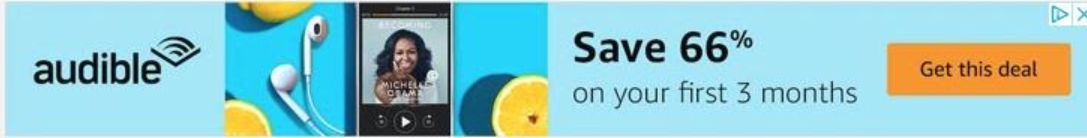

--------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation              "This banner advertises a limited-time offer from Audible, promoting a 66% discount on the first three months of their subscription service. The imagery suggests a seamless listening experience with their app and headphones, featuring a popular audiobook title. The ad targets individuals interested in exploring audiobooks and podcasts."
Intended Audience           "The target audience is anyone interested in listening to audiobooks or podcasts."
Classification              "Books and Audio Books"
Classification Levenshtein  Books and Audio Books
--------------------------  -------------------------

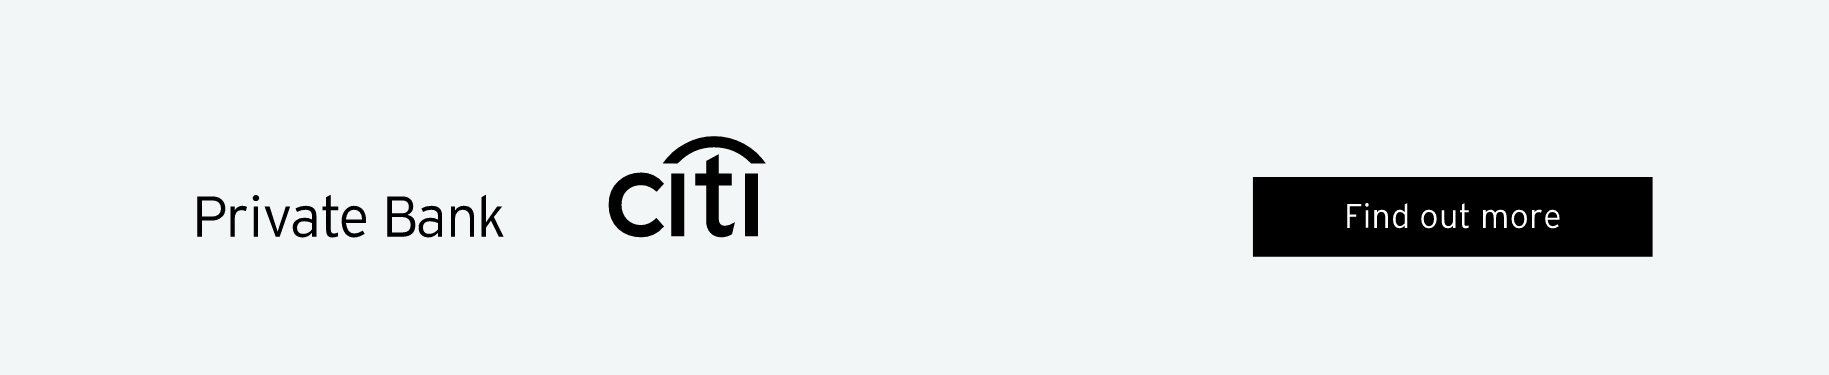

--------------------------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation              "This banner advertises Citi's Private Bank, promoting its exclusive financial services for high-net-worth individuals. The ad uses a minimalist design and clear messaging to convey a sense of sophistication and exclusivity."
Intended Audience           "The intended audience is high-net-worth individuals and families seeking tailored financial solutions and wealth management services."
Classification              "Banking"
Classification Levenshtein  Banking
--------------------------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


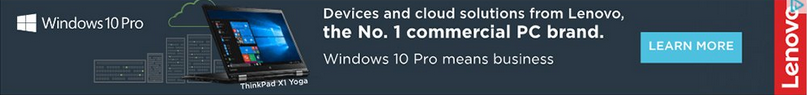

--------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation              "Lenovo is promoting its ThinkPad X1 Yoga laptop as a device for business professionals. The ad highlights the laptop's Windows 10 Pro operating system and positions Lenovo as a leading commercial PC brand. The intended message is to appeal to business users looking for reliable and powerful devices."
Intended Audience           "Business professionals looking for a reliable and powerful laptop."
Classification              "Computers"
Classification Levenshtein  Computers
--------------------------  ---------------------------------------------------------------------------------------------------------------------------------------

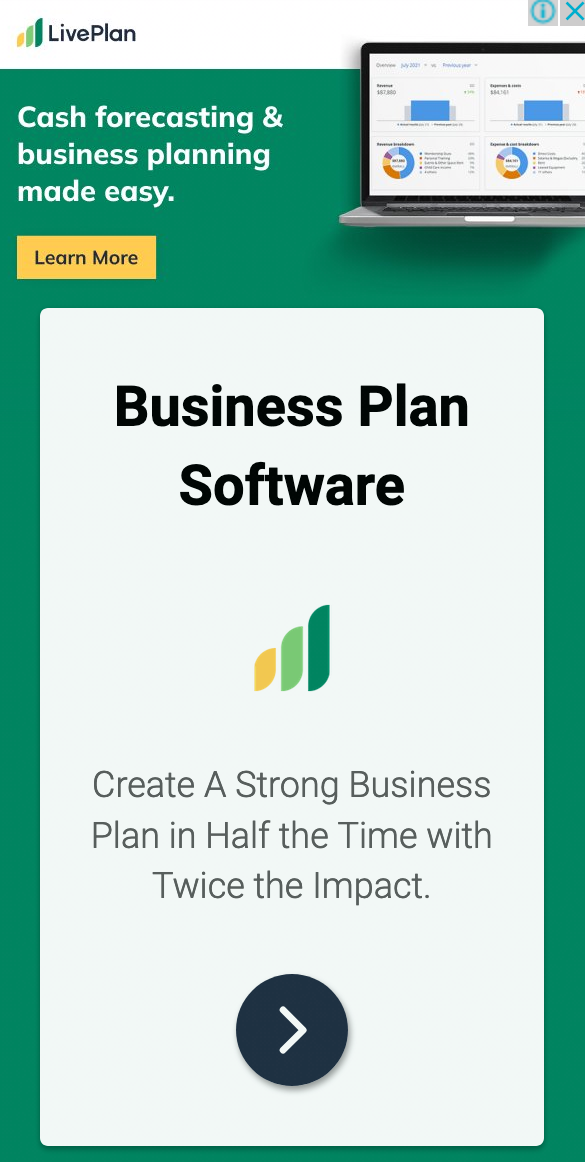

--------------------------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation              "LivePlan is a business plan software that helps create strong business plans in half the time with twice the impact. The product is advertised for its efficiency and effectiveness in business planning. The intended audience is individuals or businesses looking to create or improve their business plans."
Intended Audience           "The target audience is entrepreneurs, business owners, and anyone looking to create or improve a business plan."
Classification              "Business Services"
Classification Levenshtein  Business Services
--------------------------  --------------------------------------------------------------------

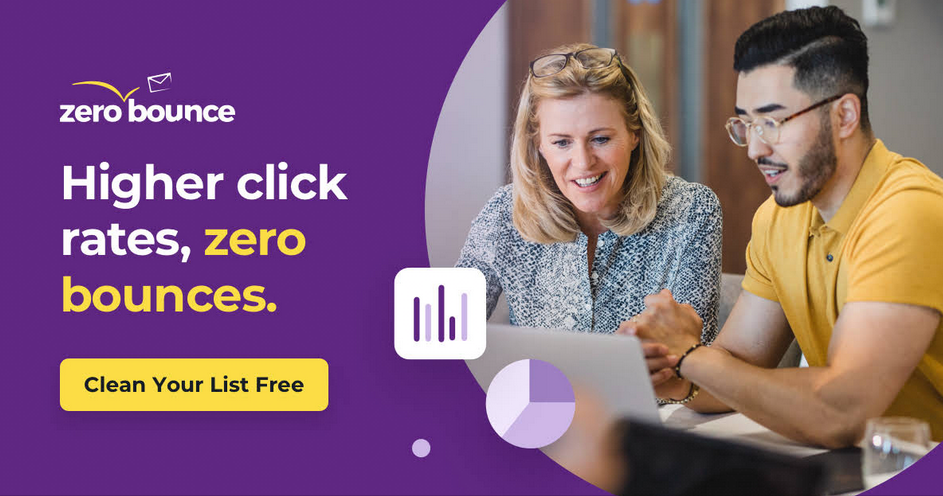

--------------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation              "The banner advertises ZeroBounce, a service that helps improve email marketing by cleaning email lists to ensure higher click rates and zero bounces. The visuals highlight a positive interaction between colleagues, suggesting improved campaign performance."
Intended Audience           "The intended audience is marketing professionals and businesses engaged in email marketing seeking to improve their campaign performance."
Classification              "Advertising and Marketing"
Classification Levenshtein  Advertising and Marketing
--------------------------  ------------------------------------------------------------------------------------------------------------------------

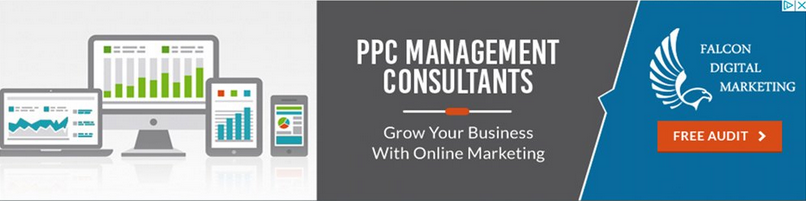

--------------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation              "The banner advertises Falcon Digital Marketing's PPC management consultant services. It highlights their expertise in growing businesses through online marketing strategies, appealing to businesses seeking to enhance their online presence and drive growth."
Intended Audience           "The target audience is businesses looking to improve their online presence and sales through pay-per-click advertising."
Classification              "Advertising and Marketing"
Classification Levenshtein  Advertising and Marketing
--------------------------  ------------------------------------------------------------------------------------------------------------------------------------------

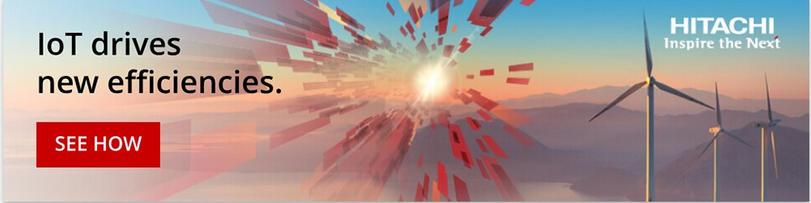

--------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation              "The banner promotes Hitachi's IoT solutions, emphasizing their ability to drive new efficiencies. The visuals suggest a focus on renewable energy, hinting at the solutions' applications in optimizing energy generation and consumption."
Intended Audience           "The intended audience is businesses in industries such as energy, looking to leverage IoT technology for increased efficiency and optimization."
Classification              "Energy Industry"
Classification Levenshtein  Energy Industry
--------------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

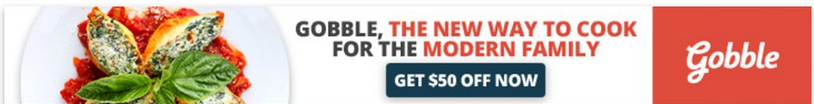

--------------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation              "Gobble is a meal kit service that offers a new way to cook for modern families. The ad emphasizes convenience and ease of use, targeting busy families who want to enjoy home-cooked meals without the hassle."
Intended Audience           "Busy families who want quick and easy home-cooked meals."
Classification              "Meal Kits"
Classification Levenshtein  Meal Kits
--------------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------  -----------------------------------------------------------------------------------------------------------------

In [78]:
gcs_client = storage.Client()

for index, row in result_df.iterrows():

    url = f"https://storage.googleapis.com/{BUCKET_LOC.split('/')[2]}/{row['uri'].split('/', 3)[-1]}"
    response = requests.get(url)

    if response.status_code == 200:
        
        image_bytes = response.content
        image = Image.open(io.BytesIO(image_bytes))
        
        print(f"Prediction for image: {row['uri']}")
        display(image)

        print(tabulate([['Interpretation', row["interpretation"]], ['Intended Audience', row["intended_audience"]], ['Classification', row["classification"]], ['Classification Levenshtein', row["classification_matched"]]]))
        if evaluate == "true":
            print(tabulate([['Reasoning', row["reasoning"]], ['Score', row["score"]]]))
                    
    else:
        print(f"Error: {response.status_code}")